# Coding Project 1 : Linear Regression

**Please write the names of all group members here:**
Zhexin Wu,
Fangyuan Sun,


---


*Note:* The provided structure for the code below is only suggestive, and if you want to structure your programs differently you may do so.

In [1]:
# %pip install seaborn optuna optuna-integration

In [2]:
# Configs
SEED = 10
TGT_NAME = "SalePrice"
TEST_SPLIT = 0.3

### Question 1 - Importing the data

In [3]:
#For Question 1, you can import the following packages:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import optuna
import optuna.distributions as opt_distr
import re
import pickle

from scipy import stats
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from optuna_integration import OptunaSearchCV
from collections import defaultdict
from typing import List, Callable, Iterable

In [4]:
# For better visualization
sns.set_theme()

In [5]:
#1.a) Import the dataset Housing.csv into Python as a pandas DataFrame and call it Housing.
#To determine whether a variable is categorical or numerical, please refer to the file description.txt.
#Remember that the first column of the csv file is an index column and should not be considered as an explanatory variable.
data_df = pd.read_csv("data/Housing.csv", index_col="Id")
data_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


Text(0.5, 1.0, 'Visualization of Missing Values, Indicated by the Bright Color')

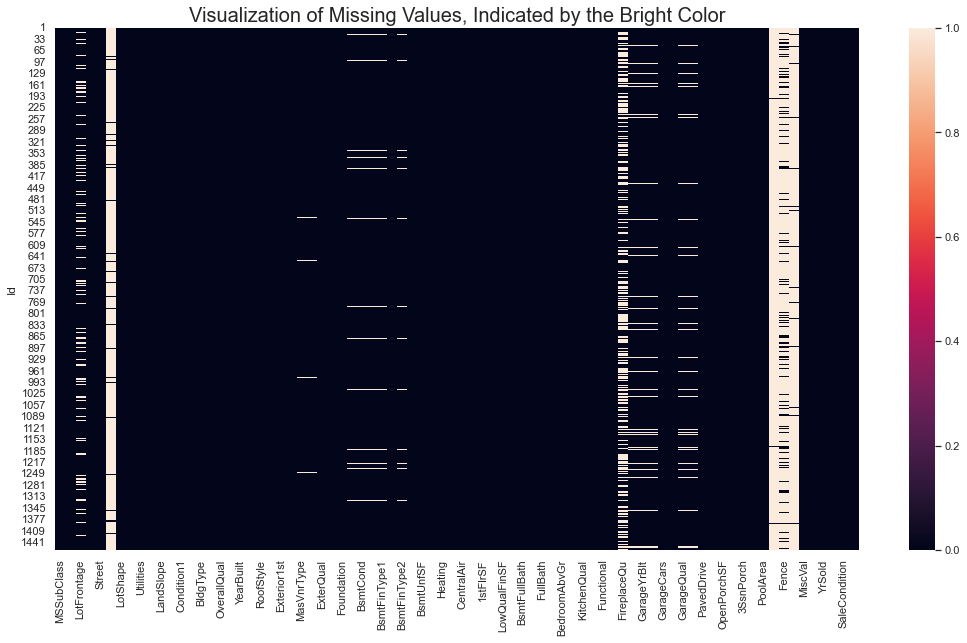

In [6]:
# Check NA
is_na = data_df.isna()
fig, axis = plt.subplots(figsize=(18, 9.6))
sns.heatmap(is_na, ax=axis)
axis.set_title(
    "Visualization of Missing Values, Indicated by the Bright Color",
    fontdict={
        "fontsize": 20
    }
)

In [7]:
"""
Read dtype from data_description.txt to ensure consistency with data_df.dtypes
"""
with open("data/data_description.txt", "r") as rf:
    data_desc = rf.read()
desc_out = re.findall(r"(\w+) *\((\w+)\):[\w ]+\n", data_desc)
desc_out_df = pd.DataFrame(desc_out, columns=["feat_name", "dtype"])
desc_out_df

,feat_name,dtype
0,LotArea,numerical
1,Street,categorical
2,Alley,categorical
3,LotShape,categorical
4,LandContour,categorical
...,...,...
59,PoolQC,categorical
60,Fence,categorical
61,MiscFeature,categorical
62,SaleType,categorical


In [8]:
data_df_categorical_feats = data_df.dtypes[data_df.dtypes == "object"].index.values
data_desc_categorical_feats = desc_out_df.loc[desc_out_df["dtype"] == "categorical", "feat_name"]
# np.all(data_df_categorical_feats == data_desc_categorical_feats)
print(f"Number of categorical features:\nFrom data_df: {data_df_categorical_feats.shape[0]}\nFrom desc: {data_desc_categorical_feats.shape[0]}")
diff_feat_names = set(data_df_categorical_feats).difference(set(data_desc_categorical_feats))
diff_feat_names = list(diff_feat_names)
print(f"Differences: {diff_feat_names}")

Number of categorical features:
From data_df: 43
From desc: 38
Differences: ['Functional', 'MSZoning', 'Exterior2nd', 'Condition2', 'BsmtFinType2']


In [9]:
data_df[diff_feat_names]

,Functional,MSZoning,Exterior2nd,Condition2,BsmtFinType2
Id,,,,,
1,Typ,RL,VinylSd,Norm,Unf
2,Typ,RL,MetalSd,Norm,Unf
3,Typ,RL,VinylSd,Norm,Unf
4,Typ,RL,Wd Shng,Norm,Unf
5,Typ,RL,VinylSd,Norm,Unf
...,...,...,...,...,...
1456,Typ,RL,VinylSd,Norm,Unf
1457,Min1,RL,Plywood,Norm,Rec
1458,Typ,RL,CmentBd,Norm,Unf


<span style="color: blue;"><strong>Conclusion:</strong></span>
1. The 5 features not included in data_description.txt are also categorical, so we can rely on `data_df.dtypes == "object"` for selecting categorical features.
1. Note that we have substantial NA's in the dataset, but according to data_description.txt, they don't mean missing values but count as one category.

<AxesSubplot: ylabel='Frequency'>

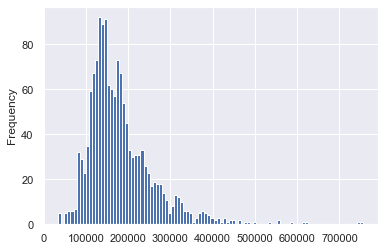

In [10]:
#1.b) Determine graphically whether the target variable SalePrice exhibits a Gaussian distribution.
data_df[TGT_NAME].plot(kind="hist", bins=100)

In [ ]:
stats.probplot(data_df[TGT_NAME], dist='norm', plot=plt)
plt.show()

<span style="color: blue;"><strong>Conclusion:</strong></span>
From the histogram we see that *SalePrice* is positively skewed, and the Q-Q plot also implies that the distribution does not seem to be Gaussian (right-skewed). Therefore, we use a log transform on it.

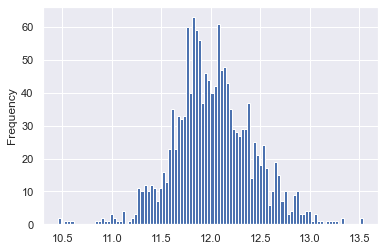

In [11]:
#If not, suggest a suitable transformation to bring SalePrice close to a Gaussian distribution (logarithmic, inverse, square-root, ...).
np.log(data_df[TGT_NAME]).plot(kind="hist", bins=100)
#Do not forget to apply this transformation to the target variable SalePrice in the dataset and perform the regressions of Q2-Q3 on this transformed target.
data_tgt_tfm_df = data_df.copy()
data_tgt_tfm_df[TGT_NAME] = np.log(data_tgt_tfm_df[TGT_NAME])

In [ ]:
stats.probplot(data_tgt_tfm_df[TGT_NAME], dist='norm', plot=plt)
plt.show()

<span style="color: blue;"><strong>Conclusion:</strong></span>
After log transformation, we see that $log(\text{Saleprice})$ is approximately Gaussian.

In [12]:
y_all = data_tgt_tfm_df.pop(TGT_NAME)
X_all = data_tgt_tfm_df.copy()
X_all.shape, y_all.shape

((1460, 79), (1460,))

In [13]:
#1.c) Replace missing values with the mean (resp. mode) of their respective columns for numerical variables (resp. categorical) using pd.fillna(...).
#Pay attention that some categorical variables admit 'NA' as a category, which is therefore not a missing value in this case.

#Use one-hot encoding for the categorical features using the default function pd.get_dummies(...). 

<span style="color: blue;"><strong>Notes:</strong></span>
- For convenience for model training, we instead decide to use `ColumnTransformer` for better integration
- Note that the transforms should be performed at runtime using statistics of the training set, especially when doing cross validation where each fit relies on different training data

In [14]:
categorical_tfm = Pipeline(
    [
        ("na_imputer", SimpleImputer(strategy="constant", fill_value="NA")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore")),  # Handling unknown categories during test time
    ]
)
col_tfm = ColumnTransformer(
    [
        ("numerical_imputer", SimpleImputer(strategy="mean"), make_column_selector(dtype_exclude=["object", "category"])),
        ("categorical_tfm", categorical_tfm, make_column_selector(dtype_include=["object", "category"])), 
    ]
)

X_all_tfm = col_tfm.fit_transform(X_all)
X_all_tfm

<1460x304 sparse matrix of type '<class 'numpy.float64'>'
	with 97976 stored elements in Compressed Sparse Row format>

In [15]:
# For inspection
X_all_tfm_df = pd.DataFrame(X_all_tfm.toarray(), columns=col_tfm.get_feature_names_out())
X_all_tfm_df

,numerical_imputer__MSSubClass,numerical_imputer__LotFrontage,numerical_imputer__LotArea,numerical_imputer__OverallQual,numerical_imputer__OverallCond,numerical_imputer__YearBuilt,numerical_imputer__YearRemodAdd,numerical_imputer__MasVnrArea,numerical_imputer__BsmtFinSF1,numerical_imputer__BsmtFinSF2,...,categorical_tfm__SaleType_ConLw,categorical_tfm__SaleType_New,categorical_tfm__SaleType_Oth,categorical_tfm__SaleType_WD,categorical_tfm__SaleCondition_Abnorml,categorical_tfm__SaleCondition_AdjLand,categorical_tfm__SaleCondition_Alloca,categorical_tfm__SaleCondition_Family,categorical_tfm__SaleCondition_Normal,categorical_tfm__SaleCondition_Partial
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
"""
Check:
- NA's are handled as a category
- There are no missing values now
"""
print(X_all_tfm_df.columns[X_all_tfm_df.columns.str.contains("NA")])
X_all_tfm_df.isna().values.sum()

Index(['categorical_tfm__Alley_NA', 'categorical_tfm__Neighborhood_NAmes',
       'categorical_tfm__MasVnrType_NA', 'categorical_tfm__BsmtQual_NA',
       'categorical_tfm__BsmtCond_NA', 'categorical_tfm__BsmtExposure_NA',
       'categorical_tfm__BsmtFinType1_NA', 'categorical_tfm__BsmtFinType2_NA',
       'categorical_tfm__Electrical_NA', 'categorical_tfm__FireplaceQu_NA',
       'categorical_tfm__GarageType_NA', 'categorical_tfm__GarageFinish_NA',
       'categorical_tfm__GarageQual_NA', 'categorical_tfm__GarageCond_NA',
       'categorical_tfm__PoolQC_NA', 'categorical_tfm__Fence_NA',
       'categorical_tfm__MiscFeature_NA'],
      dtype='object')


0

In [17]:
#1.d) Create a second pandas DataFrame from Housing without the categorical variables.
# For that, use the function df.select_dtypes and exclude the variables with type 'object' and 'category'. Call this dataset Housing2.
X_all_numerical = X_all.select_dtypes(exclude=["object", "category"])
X_all_numerical

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,460,0,40,0,0,0,0,0,8,2007
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,500,349,0,0,0,0,0,0,2,2010
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,252,0,60,0,0,0,0,2500,5,2010


### Question 2 - Linear Regression on Housing2

In [18]:
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [19]:
#2.a) Split the Housing2 data into a training set (X,Y)_train and a test set (X, Y)_test. 
#Randomly assign 70% of the observations to the training set and the remaining 30% to the test set.
X_train_numerical, X_test_numerical, y_train, y_test = train_test_split(
    X_all_numerical, 
    y_all, 
    test_size=TEST_SPLIT, 
    random_state=SEED, 
    shuffle=True
)
X_train_numerical.shape, y_train.shape, X_test_numerical.shape, y_test.shape

((1022, 36), (1022,), (438, 36), (438,))

In [20]:
def create_pipeline(model: BaseEstimator):
    categorical_tfm = Pipeline(
        [
            ("na_imputer", SimpleImputer(strategy="constant", fill_value="NA")),
            ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    col_tfm = ColumnTransformer(
        [
            ("numerical_imputer", SimpleImputer(strategy="mean"), make_column_selector(dtype_exclude=["object", "category"])),
            ("categorical_tfm", categorical_tfm, make_column_selector(dtype_include=["object", "category"])), 
        ]
    )
    pipeline = Pipeline(
        [
            ("preprocessor", col_tfm),
            ("model", model)
        ]
    )
    
    return pipeline

In [21]:
#2.b) Fit a linear regression model on the training dataset (X, Y)_train using the sklearn package.
#Output a table with the name of each feature and the associated regression coefficient. 
lr_pipeline = create_pipeline(LinearRegression())
lr_pipeline.fit(X_train_numerical, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_imputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001514688DEB0>),
                                                 ('categorical_tfm',
                                                  Pipeline(steps=[('na_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001514650A310>)])),
                ('model', LinearRegression())])

In [22]:
lr_pipeline.steps

[('preprocessor',
  ColumnTransformer(transformers=[('numerical_imputer', SimpleImputer(),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001514688DEB0>),
                                  ('categorical_tfm',
                                   Pipeline(steps=[('na_imputer',
                                                    SimpleImputer(fill_value='NA',
                                                                  strategy='constant')),
                                                   ('one_hot_encoder',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001514650A310>)])),
 ('model', LinearRegression())]

In [23]:
lr_model = lr_pipeline["model"]
intercept = lr_model.intercept_
coeffs = lr_model.coef_
feature_names = lr_pipeline["preprocessor"].get_feature_names_out()
feature_names

array(['numerical_imputer__MSSubClass', 'numerical_imputer__LotFrontage',
       'numerical_imputer__LotArea', 'numerical_imputer__OverallQual',
       'numerical_imputer__OverallCond', 'numerical_imputer__YearBuilt',
       'numerical_imputer__YearRemodAdd', 'numerical_imputer__MasVnrArea',
       'numerical_imputer__BsmtFinSF1', 'numerical_imputer__BsmtFinSF2',
       'numerical_imputer__BsmtUnfSF', 'numerical_imputer__TotalBsmtSF',
       'numerical_imputer__1stFlrSF', 'numerical_imputer__2ndFlrSF',
       'numerical_imputer__LowQualFinSF', 'numerical_imputer__GrLivArea',
       'numerical_imputer__BsmtFullBath',
       'numerical_imputer__BsmtHalfBath', 'numerical_imputer__FullBath',
       'numerical_imputer__HalfBath', 'numerical_imputer__BedroomAbvGr',
       'numerical_imputer__KitchenAbvGr',
       'numerical_imputer__TotRmsAbvGrd', 'numerical_imputer__Fireplaces',
       'numerical_imputer__GarageYrBlt', 'numerical_imputer__GarageCars',
       'numerical_imputer__GarageArea',

<span style="color: blue;"><strong>Notes:</strong></span>
- All features are numerical as is indicated by the feature names extracted from the fitted ColumnTransformer
- For better inspection, we extract the original feature names from them

In [24]:
beta_hats_df = pd.DataFrame(
    [intercept] + list(coeffs),
    index=["intercept"] + list(map(lambda feat_name: feat_name.split("__")[1], feature_names)),
    columns=["beta_hat"]
)
beta_hats_df

,beta_hat
intercept,18.140570
MSSubClass,-0.000733
LotFrontage,-0.000273
LotArea,0.000002
OverallQual,0.087042
OverallCond,0.048559
YearBuilt,0.003062
YearRemodAdd,0.000961
MasVnrArea,0.000003
BsmtFinSF1,0.000018


In [25]:
mean_squared_error.__name__

'mean_squared_error'

In [26]:
#Compare the in-sample and out-of-sample Mean Squared Error (MSE) and R^2 of your linear regression model.
def compute_metrics(metric_funcs: List[Callable], model: BaseEstimator, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    metrics_dict = defaultdict(list)
    for y_pred_iter, y_iter in zip([y_pred_train, y_pred_test], [y_train, y_test]):
        for metric_func in metric_funcs:
            metrics_dict[metric_func.__name__].append(metric_func(y_iter, y_pred_iter))
    metrics_df = pd.DataFrame(metrics_dict, index=["in-sample", "out-of-sample"])
    
    return metrics_df

metrics_df = compute_metrics(
    [mean_squared_error, r2_score],
    lr_pipeline,
    X_train_numerical,
    y_train,
    X_test_numerical,
    y_test
)
metrics_df

,mean_squared_error,r2_score
in-sample,0.021603,0.861617
out-of-sample,0.020817,0.875258


In [27]:
#2.c) (i) Compute the estimated coefficients for each explanatory variable using the numpy package. Remember that the design matrix A needs to include a column of 1's.

#	  (ii) Compute the standard error of each estimated coefficient using the numpy package.

#     (iii) Compute the (in-sample) MSE and R^2 using the numpy package.

In [28]:
# Fill NA in the training set, i.e. using an identity model for create_pipeline(.)
pass_through_pipeline = create_pipeline(FunctionTransformer())
X_train_numerical_tfm = pass_through_pipeline.fit_transform(X_train_numerical)
X_train_mat = np.concatenate([np.ones((X_train_numerical_tfm.shape[0], 1)), X_train_numerical_tfm], axis=1)
y_train_mat = y_train.values
feature_names = ["Intercept"] + list(X_train_numerical.columns)
X_train_mat.shape, y_train_mat.shape

((1022, 37), (1022,))

In [29]:
def linear_regression_inference(X_train: np.ndarray, y_train: np.ndarray, feature_names: Iterable, inv_func: Callable):
    """
    Parameters
    ----------
    inv_func: Callable
        Either np.linalg.inv(.) or np.linalg.pinv(.)
    """
    m, l = X_train.shape
    X_T_X_inv = inv_func(X_train.T @ X_train)
    
    # Estimate beta
    beta_hat = X_T_X_inv @ (X_train.T @ y_train)
    
    # Compute SE and T-statistic
    y_pred = X_train @ beta_hat
    SSE = ((y_pred - y_train) ** 2).sum()
    sigma_sq_hat = SSE / (m - l)
    se = np.sqrt(sigma_sq_hat * np.diag(X_T_X_inv))
    t_stat = beta_hat / se
    est_df = pd.DataFrame(
        {
            "beta_hat": beta_hat, 
            "SE": se,
            "t_stat": t_stat,
        },
        index=feature_names
    )
    
    # Compute in-sample MSE and R^2
    y_train_mean = y_train.mean()
    SST = ((y_train - y_train_mean) ** 2).sum()
    metrics = {}
    metrics["MSE"] = SSE / m  # More precisely, / (m - l)
    metrics["R^2"] = 1 - SSE / SST
    
    return est_df, metrics

In [30]:
# np.linalg.inv(.)
est_inv, metrics_inv = linear_regression_inference(
    X_train_mat,
    y_train_mat,
    feature_names,
    np.linalg.inv
)
print(metrics_inv)
est_inv

{'MSE': 4852.295926141039, 'R^2': -31081.68265359521}


C:\Users\lenovo\AppData\Local\Temp\ipykernel_3484\172047323.py:18: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(sigma_sq_hat * np.diag(X_T_X_inv))


,beta_hat,SE,t_stat
Intercept,3.299439e+03,3516.194229,0.938355
MSSubClass,-5.753126e-01,0.067790,-8.486746
LotFrontage,-1.471720e+00,0.124501,-11.820920
LotArea,2.122109e-04,0.000221,0.961052
OverallQual,2.780274e+01,2.951978,9.418340
OverallCond,-1.309736e+01,2.528957,-5.178954
YearBuilt,-1.871789e+00,0.162037,-11.551636
YearRemodAdd,2.311180e-01,0.168261,1.373565
MasVnrArea,1.519903e-02,0.014080,1.079448
BsmtFinSF1,-2.131417e+11,NaN,NaN


<span style="color: blue;"><strong>Note:</strong></span>
Results using standard matrix inversion are shown above.

In [31]:
# np.linalg.pinv(.)
est_pinv, metrics_pinv = linear_regression_inference(
    X_train_mat,
    y_train_mat,
    feature_names,
    np.linalg.pinv
)
print(metrics_pinv)
est_pinv

{'MSE': 0.02160292026600646, 'R^2': 0.8616167016109393}


,beta_hat,SE,t_stat
Intercept,18.140446,7.419173e+00,2.445076
MSSubClass,-0.000733,1.430360e-04,-5.121529
LotFrontage,-0.000273,2.626978e-04,-1.038682
LotArea,0.000002,4.659113e-07,3.881226
OverallQual,0.087042,6.228676e-03,13.974441
OverallCond,0.048559,5.336102e-03,9.100130
YearBuilt,0.003062,3.418976e-04,8.955720
YearRemodAdd,0.000961,3.550318e-04,2.707686
MasVnrArea,0.000003,2.970960e-05,0.114042
BsmtFinSF1,0.000018,1.330468e-05,1.386096


<span style="color: blue;"><strong>Note:</strong></span>
Results using pseudo-inversion are shown above.

In [32]:
np.allclose(est_pinv["beta_hat"], beta_hats_df["beta_hat"])

True

In [33]:
np.linalg.matrix_rank(X_train_mat), X_train_mat.shape

(35, (1022, 37))

In [34]:
#     (iv) Do the results change using pseudoinversion instead of standard matrix inversion in (i) and (ii)?

<span style="color: blue;"><strong>Discussion:</strong></span>
1. We see different results from using inverse and pseudo-inverse
1. The result from using inverse doesn't make sense, because the training matrix is singular, i.e. it has rank 35 but there are 37 columns
1. The result from using pseudo-inverse agrees with the result from `sklearn.linear_model.LinearRegression`

In [35]:
#     (v) Compare your results (i), (ii), (iii) (with and without pseudoinversion) to the output of the sm.OLS function. 
ols_model = sm.OLS(y_train_mat, sm.add_constant(X_train_mat, prepend=True))
ols_res = ols_model.fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     180.7
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:39:05   Log-Likelihood:                 509.49
No. Observations:                1022   AIC:                            -949.0
Df Residuals:                     987   BIC:                            -776.5
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1406      7.412      2.448      0.015       3.596      32.685
x1            -0.0007      0.000     -5.127      0.000      -0.001      -0.000
x2            -0.0003      0.000     -1.040      0.299      -0.001       0.000
x3          1.808e-06   4.65e-07      3.885      0.000    8.95e-07    2.72e-06
x4             0.0870      0.006     13.989      0.000       0.075       0.099
x5             0.0486      0.005      9.109      0.000       0.038       0.059
x6             0.0031      0.000      8.965      0.000       0.002       0.004
x7             0.0010      0.000      2.710      0.007       0.000       0.002
x8          3.388e-06   2.97e-05      0.114      0.909   -5.49e-05    6.16e-05
x9          1.844e-05   1.33e-05      1.389      0.165   -7.61e-06    4.45e-05
x10         2.101e-06   2.49e-05      0.084      0.933   -4.67e-05    5.09e-05
x11         1.325e-06   1.29e-05      0.103      0.918   -2.39e-05    2.66e-05
x12         2.187e-05    1.8e-05      1.215      0.225   -1.34e-05    5.72e-05
x13         5.616e-05   3.06e-05      1.833      0.067   -3.95e-06       0.000
x14          2.88e-05   2.85e-05      1.011      0.312   -2.71e-05    8.47e-05
x15         5.079e-05   7.16e-05      0.710      0.478   -8.96e-05       0.000
x16            0.0001   2.75e-05      4.933      0.000    8.17e-05       0.000
x17            0.0672      0.014      4.910      0.000       0.040       0.094
x18            0.0275      0.022      1.256      0.209      -0.015       0.070
x19            0.0434      0.015      2.935      0.003       0.014       0.072
x20            0.0098      0.014      0.694      0.488      -0.018       0.037
x21           -0.0082      0.009     -0.909      0.363      -0.026       0.009
x22           -0.0738      0.029     -2.549      0.011      -0.131      -0.017
x23            0.0208      0.006      3.206      0.001       0.008       0.033
x24            0.0393      0.009      4.307      0.000       0.021       0.057
x25           -0.0001      0.000     -0.373      0.710      -0.001       0.001
x26            0.0772      0.014      5.332      0.000       0.049       0.106
x27        -2.579e-05   5.06e-05     -0.510      0.610      -0.000    7.35e-05
x28            0.0002   4.14e-05      4.311      0.000    9.73e-05       0.000
x29         9.499e-05   7.93e-05      1.197      0.231   -6.07e-05       0.000
x30            0.0002   8.62e-05      2.067      0.039       9e-06       0.000
x31            0.0003      0.000      1.941      0.053   -3.21e-06       0.001
x32            0.0004   9.63e-05      3.767      0.000       0.000       0.001
x33           -0.0004      0.000     -2.784      0.005      -0.001      -0.000
x34         -1.58e-06   8.13e-06     -0.194      0.846   -1.75e-05    1.44e-05
x35            0.0020      0.002      1.146      0.252      -0.001       0.005
x3

In [36]:
ols_res_df = pd.DataFrame(
    {
        "beta_hat": ols_res.params,
        "se": ols_res.bse,
        "t_stat": ols_res.tvalues,
    },
    index=feature_names,
)
ols_res_df

,beta_hat,se,t_stat
Intercept,18.140570,7.411651e+00,2.447575
MSSubClass,-0.000733,1.428910e-04,-5.126727
LotFrontage,-0.000273,2.624315e-04,-1.039735
LotArea,0.000002,4.654390e-07,3.885164
OverallQual,0.087042,6.222362e-03,13.988621
OverallCond,0.048559,5.330693e-03,9.109365
YearBuilt,0.003062,3.415510e-04,8.964807
YearRemodAdd,0.000961,3.546719e-04,2.710434
MasVnrArea,0.000003,2.967949e-05,0.114158
BsmtFinSF1,0.000018,1.327556e-05,1.389237


In [37]:
np.allclose(est_pinv.values[:, 0], ols_res_df.values[:, 0])

True

In [38]:
np.allclose(est_pinv.values[:, 1], ols_res_df.values[:, 1])

False

<span style="color: blue;"><strong>Discussion:</strong></span>
1. We see the beta estimates by pseudo-inverse are agreed by sm.OLS
1. But there are small discrepancies in SE. The reason is sm.OLS eliminates the colinearity first, thus resulting in fewer features, thus smaller SEs

In [39]:
#2.d) Suggest instead a second-order polynomial regression model (including all quadratic and mixed terms) to predict the (transformed) SalePrice.

#Does this improve the linear regression model 2.b)? 

#What happens with higher-order polynomial regression models?

<span style="color: blue;"><strong>Sanity check on polynomial features:</strong></span>
- Bias
- $x_i^2 \quad \forall i \in [d]$
- $x_i \cdot x_j \quad \forall i, j \in [d],\ i \neq j$

In [40]:
tfm = create_pipeline(PolynomialFeatures(degree=2))
X_train_tfm_temp = tfm.fit_transform(X_train_numerical)
X_train_tfm_temp_df = pd.DataFrame(X_train_tfm_temp, columns=tfm["model"].get_feature_names_out())
X_train_tfm_temp_df.columns

Index(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       ...
       'x32^2', 'x32 x33', 'x32 x34', 'x32 x35', 'x33^2', 'x33 x34', 'x33 x35',
       'x34^2', 'x34 x35', 'x35^2'],
      dtype='object', length=703)

In [41]:
# Fit a LR model with all features
model = Pipeline([
    ("poly_feat", PolynomialFeatures(degree=2)),
    ("model", LinearRegression(fit_intercept=False)),  # Already added bias term using PolynomialFeatures()
])
pipeline = create_pipeline(model)
pipeline.fit(X_train_numerical, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_imputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000151489294F0>),
                                                 ('categorical_tfm',
                                                  Pipeline(steps=[('na_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015148929A30>)])),
                ('model',
                 Pipeline(steps=[('poly_feat', PolynomialFeatures()),
                                 ('model',
                                  LinearRegression(fit_intercept=False))]))])

In [42]:
metrics_poly_df = compute_metrics(
    [mean_squared_error, r2_score],
    pipeline,
    X_train_numerical,
    y_train,
    X_test_numerical,
    y_test
)
metrics_poly_df

,mean_squared_error,r2_score
in-sample,0.005140,0.967077
out-of-sample,11146.724647,-66791.852472


In [43]:
# Compare with LR
metrics_df

,mean_squared_error,r2_score
in-sample,0.021603,0.861617
out-of-sample,0.020817,0.875258


<span style="color: blue;"><strong>Discussion:</strong></span>

1. The polynomial features result in heavy overfitting. We can see out-of-sample MSE is much bigger than in-sample, and out-of-sample $R^2$ is highly negative. This result should eliminate the use of even higher polynomial features.
1. Since polynomial features underperform the original features in out-of-sample dataset severely, there's no improvement.

### Question 3 - Regularization techniques on Housing

In [44]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

In [45]:
# Ensure the same indices
train_inds = X_train_numerical.index
test_inds = X_test_numerical.index
X_train, y_train = X_all.loc[train_inds], y_all.loc[train_inds]
X_test, y_test = X_all.loc[test_inds], y_all.loc[test_inds]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1022, 79), (1022,), (438, 79), (438,))

In [46]:
#3.a) Perform again a linear regression for the (transformed) SalePrice using this time the full Housing DataFrame. 

#How do the in-sample and out-of-sample MSE and R^2 metrics compare to the results of Question 2.b) on the Housing2 DataFrame?
pipeline = create_pipeline(LinearRegression())
pipeline.fit(X_train, y_train)
metrics_lr_df = compute_metrics(
    [mean_squared_error, r2_score],
    pipeline,
    X_train,
    y_train,
    X_test,
    y_test,
)
metrics_lr_df

,mean_squared_error,r2_score
in-sample,0.011887,0.923856
out-of-sample,0.017565,0.894748


In [47]:
# Compare with LR with only numerical features
metrics_df

,mean_squared_error,r2_score
in-sample,0.021603,0.861617
out-of-sample,0.020817,0.875258


<span style="color: blue;"><strong>Discussion:</strong></span>

Using all features improves the model performance both for training and test samples.

In [48]:
#3.b)  Implement the truncated pseudoinverse, Ridge and Lasso regularization techniques. 
#Use 8-fold cross-validation to tune the hyperparameters of each regularization technique based on the MSE metric.

#Compare their performance in terms of in-sample and out-of-sample MSE with the linear regressions of Questions 2.b) and 3.a).
def hyperparam_tuning(model: BaseEstimator, param_distr: dict, X_train, y_train, **kwargs):
    """
    Using Optuna for fast hyperparameter tuning.
    """
    optuna_search = OptunaSearchCV(
        estimator=model,
        param_distributions=param_distr,
        **kwargs,
    )
    optuna_search.fit(X_train, y_train)
    
    return optuna_search

In [49]:
OPTUNA_SEARCH_CONFIG = {
    "cv": 8,
    "n_trials": 50,
    "random_state": SEED,
    "n_jobs": -1,
    "scoring": "neg_mean_squared_error",
}

### Truncated Pseudo-Inverse

Truncated pseudo-inverse is equivalent as performing truncated SVD on the features and then performing linear regression.

We first inspect the distribution of the design matrix's singular values. Note we use the full dataset for the inspection, but for model training we use the training set or cross-validation.

Shape of all features after transform: (1460, 304)


Text(0, 0.5, 'Value')

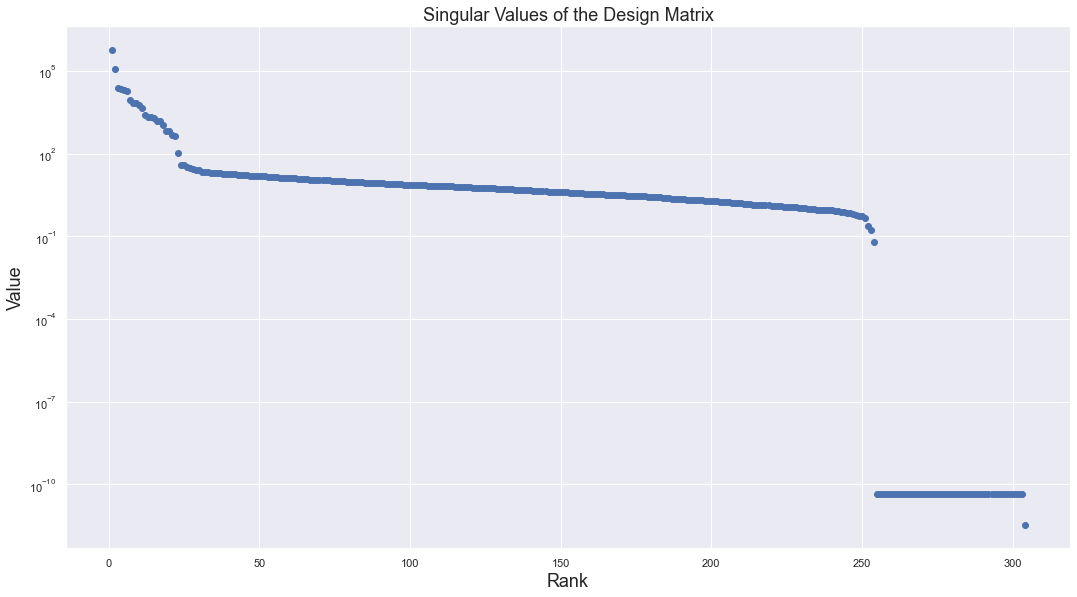

In [50]:
print(f"Shape of all features after transform: {X_all_tfm_df.shape}")
U, S, Vh = np.linalg.svd(X_all_tfm_df)
fig, axis = plt.subplots(figsize=(18, 9.6))
axis.scatter(np.arange(S.shape[0]) + 1, S)
axis.set_yscale("log")
font_dict = {
    "fontsize": 18,
}
axis.set_title("Singular Values of the Design Matrix", fontdict=font_dict)
axis.set_xlabel("Rank", fontdict=font_dict)
axis.set_ylabel("Value", fontdict=font_dict)

From the plot above, we can choose the maximum number of singular values kept is around 260, and we should keep the large ones i.e. up to approximate the 30th singular value.

In [51]:
model = Pipeline([
    ("truncated_svd", TruncatedSVD(algorithm="arpack")),
    ("estimator", LinearRegression()),
])
pipeline = create_pipeline(model)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_imputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001514A352F10>),
                                                 ('categorical_tfm',
                                                  Pipeline(steps=[('na_imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001514A3BB640>)])),
                ('model',
                 Pipeline(steps=[('truncated_svd',
                                  TruncatedSVD(algorithm='arpack')),
                                 ('estimator', LinearRegression())]))])

In [52]:
param_distr = {
    "model__truncated_svd__n_components": opt_distr.IntDistribution(30, 260),
}
optuna_search_truncated_pinv = hyperparam_tuning(
    pipeline, 
    param_distr,
    X_train,
    y_train,
    **OPTUNA_SEARCH_CONFIG,
)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3484\2729002508.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-09-27 17:39:08,349] A new study created in memory with name: no-name-20148c79-fd24-4d2b-873d-2dae34af1d77
[I 2024-09-27 17:40:10,214] Trial 0 finished with value: -0.024884586583069856 and parameters: {'model__truncated_svd__n_components': 106}. Best is trial 0 with value: -0.024884586583069856.
[I 2024-09-27 17:40:10,887] Trial 5 finished with value: -0.025894170697697266 and parameters: {'model__truncated_svd__n_components': 136}. Best is trial 0 with value: -0.024884586583069856.
[I 2024-09-27 17:40:11,854] Trial 2 finished with value: -0.029986839225595342 and parameters: {'model__truncated_svd__n_components': 217}. Best is trial 0 with value: -0.024884586583069856.
[I 2024-09-27 17:40:12,535] Trial 9 finished with value: -0.025941364185325846 and parameters:

[I 2024-09-27 17:42:32,665] Trial 42 finished with value: -0.024884586545410006 and parameters: {'model__truncated_svd__n_components': 106}. Best is trial 35 with value: -0.024646674904511844.
[I 2024-09-27 17:42:33,136] Trial 43 finished with value: -0.024653612711036936 and parameters: {'model__truncated_svd__n_components': 103}. Best is trial 35 with value: -0.024646674904511844.
[I 2024-09-27 17:42:33,558] Trial 44 finished with value: -0.02432857674441747 and parameters: {'model__truncated_svd__n_components': 99}. Best is trial 44 with value: -0.02432857674441747.
[I 2024-09-27 17:42:33,983] Trial 45 finished with value: -0.024485311084009885 and parameters: {'model__truncated_svd__n_components': 100}. Best is trial 44 with value: -0.02432857674441747.
[I 2024-09-27 17:42:34,415] Trial 46 finished with value: -0.024661362989129014 and parameters: {'model__truncated_svd__n_components': 101}. Best is trial 44 with value: -0.02432857674441747.
[I 2024-09-27 17:42:34,814] Trial 47 fin

In [53]:
print(f"The best params are {optuna_search_truncated_pinv.best_params_}")
print(f"The best avg MSE from CV is {-optuna_search_truncated_pinv.best_score_:.5f}")

The best params are {'model__truncated_svd__n_components': 97}
The best avg MSE from CV is 0.02414


In [69]:
# with open("dev/truncated_pinv_optuna_CV.pkl", "wb") as wf:
#     pickle.dump(optuna_search_truncated_pinv, wf)

# with open("dev/truncated_pinv_optuna_CV.pkl", "rb") as rf:
#     optuna_search_truncated_pinv = pickle.load(rf)

In [73]:
metrics_truncated_pinv_df = compute_metrics(
    [mean_squared_error, r2_score],
    optuna_search_truncated_pinv.best_estimator_,
    X_train,
    y_train,
    X_test,
    y_test,
)
metrics_truncated_pinv_df

,mean_squared_error,r2_score
in-sample,0.015699,0.899435
out-of-sample,0.019424,0.883607


### Ridge

In [56]:
model = Ridge(random_state=SEED)
pipeline = create_pipeline(model)
param_distr = {
    "model__alpha": opt_distr.FloatDistribution(1e-8, 10, log=True),
}
optuna_search_ridge = hyperparam_tuning(
    pipeline, 
    param_distr,
    X_train,
    y_train,
    **OPTUNA_SEARCH_CONFIG,
)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3484\2729002508.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-09-27 17:42:41,552] A new study created in memory with name: no-name-90f7b561-4bf2-40d5-bef2-adf856484e94
[I 2024-09-27 17:42:47,532] Trial 0 finished with value: -0.028354503756653337 and parameters: {'model__alpha': 0.13266376124474138}. Best is trial 0 with value: -0.028354503756653337.
[I 2024-09-27 17:42:47,544] Trial 6 finished with value: -0.02834747705771754 and parameters: {'model__alpha': 1.1839405393006181e-06}. Best is trial 6 with value: -0.02834747705771754.
[I 2024-09-27 17:42:47,573] Trial 1 finished with value: -0.02836523170117783 and parameters: {'model__alpha': 6.069479737329444e-06}. Best is trial 6 with value: -0.02834747705771754.
[I 2024-09-27 17:42:47,673] Trial 11 finished with value: -0.028349580784749126 and parameters: {'model__alpha'

[I 2024-09-27 17:43:00,399] Trial 36 finished with value: -0.0283498810490456 and parameters: {'model__alpha': 5.9426555808866965e-05}. Best is trial 13 with value: -0.028336455470902452.
[I 2024-09-27 17:43:00,419] Trial 40 finished with value: -0.02847791378608188 and parameters: {'model__alpha': 0.00010321442612771965}. Best is trial 13 with value: -0.028336455470902452.
[I 2024-09-27 17:43:00,423] Trial 44 finished with value: -0.028356527971139335 and parameters: {'model__alpha': 0.357398459945664}. Best is trial 13 with value: -0.028336455470902452.
[I 2024-09-27 17:43:00,478] Trial 45 finished with value: -0.028352931186699067 and parameters: {'model__alpha': 7.746756383528239e-05}. Best is trial 13 with value: -0.028336455470902452.
[I 2024-09-27 17:43:00,519] Trial 47 finished with value: -0.02847808584526007 and parameters: {'model__alpha': 0.00013226043446301858}. Best is trial 13 with value: -0.028336455470902452.
[I 2024-09-27 17:43:00,525] Trial 46 finished with value: -0

In [57]:
print(f"The best params are {optuna_search_ridge.best_params_}")
print(f"The best avg MSE from CV is {-optuna_search_ridge.best_score_:.5f}")

The best params are {'model__alpha': 4.752541118789812e-05}
The best avg MSE from CV is 0.02834


In [71]:
# with open("dev/ridge_optuna_CV.pkl", "wb") as wf:
#     pickle.dump(optuna_search_ridge, wf)

# with open("dev/ridge_optuna_CV.pkl", "rb") as rf:
#     optuna_search_ridge = pickle.load(rf)

In [74]:
metrics_ridge_df = compute_metrics(
    [mean_squared_error, r2_score],
    optuna_search_ridge.best_estimator_,
    X_train,
    y_train,
    X_test,
    y_test,
)
metrics_ridge_df

,mean_squared_error,r2_score
in-sample,0.020151,0.870918
out-of-sample,0.019178,0.885083


### Lasso

In [60]:
model = Lasso(random_state=SEED)
pipeline = create_pipeline(model)
param_distr = {
    "model__alpha": opt_distr.FloatDistribution(1e-8, 10, log=True),
}
optuna_search_lasso = hyperparam_tuning(
    pipeline, 
    param_distr,
    X_train,
    y_train,
    **OPTUNA_SEARCH_CONFIG,
)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3484\2729002508.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2024-09-27 17:43:01,216] A new study created in memory with name: no-name-f38c1297-d626-48a3-b1b6-f6414df3e097
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5343590669709477, tolerance: 0.013162582551526084
  model = cd_fast.sparse_enet_coordinate_descent(
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.519179891502397, tolerance: 0.013162582551526084
  model = cd_fast.sparse_enet_coordinate_descent(
D:\python\venvs\DeepLearning\lib\site-packag

[I 2024-09-27 17:43:05,139] Trial 12 finished with value: -0.0317548031797133 and parameters: {'model__alpha': 0.011011832204972097}. Best is trial 12 with value: -0.0317548031797133.
[I 2024-09-27 17:43:05,285] Trial 5 finished with value: -0.024453970757543526 and parameters: {'model__alpha': 0.0006792378349012558}. Best is trial 5 with value: -0.024453970757543526.
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.708043322878503, tolerance: 0.014255177010653748
  model = cd_fast.sparse_enet_coordinate_descent(
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.72145700175341, tolerance: 0.014255177010653748
  model = cd_fast.sparse_enet_coordinate_descent(
D:\pytho

[I 2024-09-27 17:43:08,277] Trial 21 finished with value: -0.04658986162721246 and parameters: {'model__alpha': 1.3325840541932876}. Best is trial 5 with value: -0.024453970757543526.
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7762829223953092, tolerance: 0.013976191782343462
  model = cd_fast.sparse_enet_coordinate_descent(
[I 2024-09-27 17:43:08,614] Trial 19 finished with value: -0.0358827849236424 and parameters: {'model__alpha': 0.04086252520600139}. Best is trial 5 with value: -0.024453970757543526.
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.310960562773037, tolerance: 0.013976191782343462
  model = cd_fast.sparse_enet_coordinate_descent(
D:\python

[I 2024-09-27 17:43:10,041] Trial 7 finished with value: -0.029554483979325676 and parameters: {'model__alpha': 1.4020829420062377e-07}. Best is trial 5 with value: -0.024453970757543526.
[I 2024-09-27 17:43:10,043] Trial 4 finished with value: -0.029491805421402662 and parameters: {'model__alpha': 2.508645748209536e-07}. Best is trial 5 with value: -0.024453970757543526.
[I 2024-09-27 17:43:10,090] Trial 11 finished with value: -0.029763421794695887 and parameters: {'model__alpha': 4.595103855827847e-08}. Best is trial 5 with value: -0.024453970757543526.
[I 2024-09-27 17:43:10,396] Trial 23 finished with value: -0.026063179837312628 and parameters: {'model__alpha': 0.00016429995412086025}. Best is trial 5 with value: -0.024453970757543526.
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2923393753979093, tolerance: 0.01393

D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0598839701526064, tolerance: 0.014154700321222362
  model = cd_fast.sparse_enet_coordinate_descent(
[I 2024-09-27 17:43:14,042] Trial 26 finished with value: -0.027353880871364474 and parameters: {'model__alpha': 7.146622700558058e-05}. Best is trial 5 with value: -0.024453970757543526.
[I 2024-09-27 17:43:14,070] Trial 34 finished with value: -0.024445839139380567 and parameters: {'model__alpha': 0.0007140851590500408}. Best is trial 34 with value: -0.024445839139380567.
D:\python\venvs\DeepLearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.725063491894924, tolerance: 0.014255177010653748
  model = cd_fast.sparse_enet_coordinate_descent(


In [61]:
print(f"The best params are {optuna_search_lasso.best_params_}")
print(f"The best avg MSE from CV is {-optuna_search_lasso.best_score_:.5f}")

The best params are {'model__alpha': 0.0007140851590500408}
The best avg MSE from CV is 0.02445


In [72]:
# with open("dev/lasso_optuna_CV.pkl", "wb") as wf:
#     pickle.dump(optuna_search_lasso, wf)

# with open("dev/lasso_optuna_CV.pkl", "rb") as rf:
#     optuna_search_lasso = pickle.load(rf)

In [75]:
metrics_lasso_df = compute_metrics(
    [mean_squared_error, r2_score],
    optuna_search_lasso.best_estimator_,
    X_train,
    y_train,
    X_test,
    y_test,
)
metrics_lasso_df

,mean_squared_error,r2_score
in-sample,0.011957,0.923405
out-of-sample,0.014819,0.911204


Now we compare all models.

In [64]:
metrics_all_dict = {
    "LR_numerical": metrics_df,
    "LR": metrics_lr_df,
    "truncated_pinv": metrics_truncated_pinv_df,
    "Ridge": metrics_ridge_df,
    "Lasso": metrics_lasso_df,
}
all_metrics = []
for model_name, metric_iter in metrics_all_dict.items():
    metric_local = metric_iter.copy()
    metric_local.columns = pd.MultiIndex.from_tuples([(model_name, col) for col in metric_local.columns])
    all_metrics.append(metric_local)
all_metrics_df = pd.concat(all_metrics, axis=1)
all_metrics_df

LR_numerical                           LR            \
              mean_squared_error  r2_score mean_squared_error  r2_score   
in-sample               0.021603  0.861617           0.011887  0.923856   
out-of-sample           0.020817  0.875258           0.017565  0.894748   

                  truncated_pinv                        Ridge            \
              mean_squared_error  r2_score mean_squared_error  r2_score   
in-sample               0.015699  0.899435           0.020151  0.870918   
out-of-sample           0.019424  0.883607           0.019178  0.885083   

                           Lasso            
              mean_squared_error  r2_score  
in-sample               0.011957  0.923405  
out-of-sample           0.014819  0.911204

<span style="color: blue;"><strong>Conclusion:</strong></span>

The best model is Lasso, since it achieves the lowest MSE and highest $R^2$ on both training and test set.

In [65]:
#3.c) For the  Lasso regularization technique, how many coefficients are non-zero? 

#Compare this number with the number of coefficients retained by the Ridge and truncated pseudoinverse techniques and provide an explanation.

In [66]:
# with open("dev/truncated_pinv_optuna_CV.pkl", "rb") as rf:
#     optuna_search_truncated_pinv = pickle.load(rf)

# with open("dev/ridge_optuna_CV.pkl", "rb") as rf:
#     optuna_search_ridge = pickle.load(rf)

# with open("dev/lasso_optuna_CV.pkl", "rb") as rf:
#     optuna_search_lasso = pickle.load(rf)

coeffs_ridge = optuna_search_ridge.best_estimator_["model"].coef_
coeffs_lasso = optuna_search_lasso.best_estimator_["model"].coef_
# For convenience of counting nonzeros, we pad the coeffs from truncated pinv with zeros
coeffs_truncated_pinv = np.zeros(coeffs_ridge.shape)  # (K_full,)
coeffs_truncated_pinv_model = optuna_search_truncated_pinv.best_estimator_["model"]["estimator"].coef_  # (K,), where K_full < K 
coeffs_truncated_pinv[:coeffs_truncated_pinv_model.shape[0]] = coeffs_truncated_pinv_model
coeffs_df = pd.DataFrame(
    {
        "truncated_pinv": coeffs_truncated_pinv,
        "ridge": coeffs_ridge,
        "lasso": coeffs_lasso,
    }
)
eps = 1e-6
num_non_zeros_df = (np.abs(coeffs_df) > eps).sum()
print(f"Number of non-zeros with threshold {eps}")
num_non_zeros_df

Number of non-zeros with threshold 1e-06


truncated_pinv     97
ridge             294
lasso             102
dtype: int64

<span style="color: blue;"><strong>Discussion:</strong></span>
1. Lasso has fewer non-zero coefficients than Ridge. The reason is that Lasso tends to shrink coefficients towards 0.
1. Truncated pseudo-inverse has a pre-set number of nonzeros, and in our case, it's smaller than number of non-zeros of Lasso.
1. From the comparison of MSE and $R^2$, Lasso achieves the best tradeoff between bias (too few non-zero coefficients) and variance (too many non-zero coefficients). 

In [67]:
#3.d) Based on your findings from Questions 2 and 3, which model would you recommend? Justify your choice.

<span style="color: blue;"><strong>Recommendation: Lasso</strong></span>
1. From the perspective of metrics on the training and test set, Lasso outperforms all other models.
1. From the analysis on the number of non-zero coefficients, Lasso has the best tradeoff between bias and variance. It also automatically performs feature selection, leading to better interpretability.